In [1]:
%load_ext autoreload
%autoreload 2

# import logging
import torch
import pytorch_lightning as pl

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
# import warnings

# warnings.filterwarnings('ignore')
# loggabsping.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [2]:
region_to_utc = {
    'Chelyabinsk': '+05:00',
    'Bashkortostan Republic': '+05:00',
    'St.-Petersburg': '+03:00',
    'Moscow': '+03:00',
    'Rostov': '+03:00',
    'Moscow Oblast': '+03:00',
    'Kursk Oblast': '+03:00',
    'Kemerovo Oblast': '+07:00',
    'Arkhangelskaya': '+03:00',
    'Tomsk Oblast': '+07:00',
    'Novosibirsk Oblast': '+07:00',
    'Sverdlovsk Oblast': '+05:00',
    'Leningradskaya Oblast': '+03:00',
    'Krasnodar Krai': '+03:00',
    'Tatarstan Republic': '+03:00',
    'Belgorod Oblast': '+03:00',
    'Kuzbass': '+07:00',
    'Udmurtiya Republic': '+04:00',
    'Chuvashia': '+03:00',
    'Ryazan Oblast': '+03:00',
    'Perm Krai': '+05:00',
    'Sakha': '+09:00',
    'Orenburg Oblast': '+05:00',
    'Primorye': '+10:00',
    'Zabaykalskiy Transbaikal Kray': '+09:00',
    'Bryansk Oblast': '+03:00',
    'Tver Oblast': '+03:00',
    'Stavropol Kray': '+03:00',
    'Khabarovsk': '+10:00',
    'Penza Oblast': '+03:00',
    'Mariy-El Republic': '+03:00',
    'Smolensk Oblast': '+03:00',
    'Tambov Oblast': '+03:00',
    'Novgorod Oblast': '+03:00',
    'Khakasiya Republic': '+07:00',
    'Ulyanovsk': '+04:00',
    'Volgograd Oblast': '+03:00',
    'Irkutsk Oblast': '+08:00',
    'Komi': '+03:00',
    'Nizhny Novgorod Oblast': '+03:00',
    'Krasnoyarsk Krai': '+07:00',
    'Kurgan Oblast': '+05:00',
    'Kirov Oblast': '+03:00',
    'Omsk Oblast': '+06:00',
    'Vladimir Oblast': '+03:00',
    'Yaroslavl Oblast': '+03:00',
    'Saratov Oblast': '+04:00',
    'Khanty-Mansia': '+05:00',
    'Tula Oblast': '+03:00',
    'Amur Oblast': '+09:00',
    'Altay Kray': '+07:00',
    'Buryatiya Republic': '+08:00',
    'Dagestan': '+03:00',
    'Kaluga Oblast': '+03:00',
    'Kaliningrad Oblast': '+02:00',
    'Murmansk': '+03:00',
    'Samara Oblast': '+04:00',
    'Stavropol Kray': '+03:00',
    'Voronezh Oblast': '+03:00',
    'Kursk': '+03:00',
    'Sverdlovsk': '+05:00',
    'Karelia': '+03:00',
    'Lipetsk Oblast': '+03:00',
    'Adygeya Republic': '+03:00',
    'Ivanovo Oblast': '+03:00',
    'Oryol Oblast': '+03:00',
    'Tula': '+03:00',
    'Kamchatka': '+12:00',
    'Tyumen Oblast': '+05:00',
    'Krasnodarskiy': '+03:00',
    'Krasnoyarskiy': '+07:00',
    'Pskov Oblast': '+03:00',
    'Crimea': '+03:00',
    'Chechnya': '+03:00',
    'Saratovskaya Oblast': '+04:00',
    'Kalmykiya Republic': '+03:00',
    'North Ossetia–Alania': '+03:00',
    'Vologda Oblast': '+03:00',
    'Karachayevo-Cherkesiya Republic': '+03:00',
    'Voronezh': '+03:00',
    'Chukotka': '+12:00',
    'Mordoviya Republic': '+03:00',
    'Kostroma Oblast': '+03:00',
    'Yamalo-Nenets': '+05:00',
    'Magadan Oblast': '+11:00',
    'Altai': '+07:00',
    'Vladimir': '+03:00',
    'Ivanovo': '+03:00',
    'Astrakhan Oblast': '+04:00',
    'Penza': '+03:00',
    'Kabardino-Balkariya Republic': '+03:00',
    'Jaroslavl': '+03:00',
    'Sakhalin Oblast': '+11:00',
    'Sebastopol City': '+03:00',
    'Tyumen Oblast': '+05:00',
    'Kirov': '+03:00',
    'Orel Oblast': '+03:00',
    'Omsk': '+06:00',
    'Smolenskaya Oblast': '+03:00',
    'Nenets': '+03:00',
    'Tver Oblast': '+03:00',
    'Jewish Autonomous Oblast': '+10:00',
    'Ingushetiya Republic': '+03:00',
    'Kaluga': '+03:00',
    'Kaliningrad': '+02:00',
    'North Ossetia': '+03:00',
    'Perm': '+05:00',
    'Smolensk': '+03:00',
    'Primorskiy Maritime Kray': '+10:00',
    'Vologda': '+03:00',
    'Stavropol Krai': '+03:00',
    'Astrakhan': '+04:00',
    'Transbaikal Territory': '+09:00',
    'Tambov': '+03:00',
    'Tyva Republic': '+07:00',
    'Arkhangelsk Oblast': '+03:00'
}

# Define a function to convert local time to UTC
def convert_to_utc(row):
    # Get the UTC offset from the mapping
    utc_offset = int(region_to_utc.get(row['region'], '+03:00').split(":")[0][1:]) # Default to UTC if region not found
    # Convert the local time to UTC
    local_time = row['event_timestamp']
    utc_time = local_time.tz_convert('Etc/GMT+3')  # Localizing to GMT+3
    utc_time = utc_time.tz_convert(f'Etc/GMT+{utc_offset}').value # Convert to the appropriate UTC
    return utc_time


In [3]:
# 2.1. Load Data
train_events = pd.read_csv('train_events.csv')
video_info = pd.read_csv('video_info_v2.csv')
train_targets = pd.read_csv('train_targets.csv')

In [4]:
# 2.2. Merge DataFrames
data = train_events.merge(video_info, on='rutube_video_id', how='left')
#data = data.merge(train_targets, on='viewer_uid', how='left')

# 2.3. Convert event_timestamp to datetime
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])


In [5]:
data['event_timestamp'] = data.apply(convert_to_utc, axis=1)

In [6]:
data.shape

(1759616, 13)

In [7]:
from ptls.preprocessing import PandasDataPreprocessor
import pickle

with open('preprocessor_new', 'rb') as f:
    preprocessor = pickle.load(f)

In [8]:
dataset = preprocessor.transform(data)

In [9]:
dataset = sorted(dataset, key=lambda x: x['viewer_uid'])
train_targets = train_targets.sort_values(by=['viewer_uid'])

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(144009, 36003)

In [11]:
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.supervised import SequenceToTarget

In [12]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'total_watchtime': 'identity','duration':'identity'},
    embeddings={
        'category':{'in': 128, 'out': 16},
        'author_id':{'in': 128, 'out': 64},
        'ua_client_name':{'in': 128, 'out': 16},
        'rutube_video_id':{'in': 128, 'out': 64},
        'ua_client_type':{'in': 16, 'out': 16},
        'ua_os':{'in': 16, 'out': 16},
        'ua_device_type':{'in': 16, 'out': 16},
        'title':{'in': 128, 'out': 64},
        'region':{'in': 16, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

In [13]:
seq_encoder.load_state_dict(torch.load('coles-title2.pt'))


model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [14]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    precision=16,
    max_epochs=120,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else "auto",
    enable_progress_bar=True,
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [15]:
# embedding inference

from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=128)
train_embeds = torch.vstack(trainer.predict(model, train_dl,))

test_dl = inference_data_loader(test, num_workers=0, batch_size=128)
test_embeds = torch.vstack(trainer.predict(model, test_dl,))

train_embeds.shape, test_embeds.shape

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(torch.Size([144009, 256]), torch.Size([36003, 256]))

In [16]:
emb_train = train_embeds.numpy()
emb_test = test_embeds.numpy()

y_train_sex, y_test_sex = train_test_split(train_targets, test_size=0.2, random_state=42)
y_train_age, y_test_age = train_test_split(train_targets, test_size=0.2, random_state=42)
y_train_age, y_test_age = y_train_age['age_class'], y_test_age['age_class']
y_train_sex, y_test_sex = y_train_sex['sex'], y_test_sex['sex']

In [17]:
from lightgbm import LGBMClassifier
# 2.11. Initialize and Train CatBoost Classifier
model = LGBMClassifier(num_iter = 1000
)

model.fit(emb_train, y_train_age, eval_set=(emb_test, y_test_age))

# 2.12. Predictions and Evaluation
y_pred = model.predict(emb_test)
f1 = f1_score(y_test_age, y_pred, average='weighted')
print(f'Weighted F1-score: {f1:.4f}')

[LightGBM] [Warning] Unknown parameter: num_iter
[1]	valid_0's multi_logloss: 1.20339
[2]	valid_0's multi_logloss: 1.19424
[3]	valid_0's multi_logloss: 1.18615
[4]	valid_0's multi_logloss: 1.17902
[5]	valid_0's multi_logloss: 1.17265
[6]	valid_0's multi_logloss: 1.16715
[7]	valid_0's multi_logloss: 1.16205
[8]	valid_0's multi_logloss: 1.15724
[9]	valid_0's multi_logloss: 1.1529
[10]	valid_0's multi_logloss: 1.14915
[11]	valid_0's multi_logloss: 1.14561
[12]	valid_0's multi_logloss: 1.14248
[13]	valid_0's multi_logloss: 1.13951
[14]	valid_0's multi_logloss: 1.13695
[15]	valid_0's multi_logloss: 1.13458
[16]	valid_0's multi_logloss: 1.13238
[17]	valid_0's multi_logloss: 1.13045
[18]	valid_0's multi_logloss: 1.12852
[19]	valid_0's multi_logloss: 1.12674
[20]	valid_0's multi_logloss: 1.12522
[21]	valid_0's multi_logloss: 1.1237
[22]	valid_0's multi_logloss: 1.12223
[23]	valid_0's multi_logloss: 1.12097
[24]	valid_0's multi_logloss: 1.11971
[25]	valid_0's multi_logloss: 1.1186
[26]	valid_0'

In [18]:
from lightgbm import LGBMClassifier
# 2.11. Initialize and Train CatBoost Classifier
model = LGBMClassifier(
)

model.fit(emb_train, y_train_sex, eval_set=(emb_test, y_test_sex))

# 2.12. Predictions and Evaluation
y_pred = model.predict(emb_test)
acc = accuracy_score(y_test_sex, y_pred)
print(f'Acc: {acc:.4f}')

[1]	valid_0's binary_logloss: 0.667648
[2]	valid_0's binary_logloss: 0.646528
[3]	valid_0's binary_logloss: 0.629122
[4]	valid_0's binary_logloss: 0.614184
[5]	valid_0's binary_logloss: 0.6018
[6]	valid_0's binary_logloss: 0.591063
[7]	valid_0's binary_logloss: 0.581936
[8]	valid_0's binary_logloss: 0.574032
[9]	valid_0's binary_logloss: 0.567202
[10]	valid_0's binary_logloss: 0.561342
[11]	valid_0's binary_logloss: 0.556198
[12]	valid_0's binary_logloss: 0.551372
[13]	valid_0's binary_logloss: 0.547811
[14]	valid_0's binary_logloss: 0.544248
[15]	valid_0's binary_logloss: 0.54126
[16]	valid_0's binary_logloss: 0.538546
[17]	valid_0's binary_logloss: 0.536347
[18]	valid_0's binary_logloss: 0.534231
[19]	valid_0's binary_logloss: 0.532259
[20]	valid_0's binary_logloss: 0.530574
[21]	valid_0's binary_logloss: 0.529096
[22]	valid_0's binary_logloss: 0.527692
[23]	valid_0's binary_logloss: 0.526421
[24]	valid_0's binary_logloss: 0.525189
[25]	valid_0's binary_logloss: 0.524163
[26]	valid_0

In [19]:
df_train = pd.DataFrame(emb_train)
df_train['age'] = y_train_age
df_test= pd.DataFrame(emb_test)
df_test['age'] = y_test_age

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt

# 1. Load data
train = df_train
test = df_test


X = pd.DataFrame(emb_train)
y = pd.DataFrame(y_train_age)
X_test = pd.DataFrame(emb_test)

# 2. Cross-validation setup
n_splits = 5
seed = 42
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# 3. Initialize predictions
oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
test_preds = np.zeros((X_test.shape[0], len(np.unique(y))))

# 4. LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'seed': seed,
    'verbose': -1
}

# 5. Training and prediction
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}')
    
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    valid_preds = model.predict(X_valid, num_iteration=model.best_iteration)
    oof_preds[valid_idx] = valid_preds
    
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / n_splits
    
    # Feature importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = list(range(256))
    fold_importance['importance'] = model.feature_importance(importance_type='gain')
    fold_importance['fold'] = fold + 1
    if fold == 0:
        feature_importance = fold_importance
    else:
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    del X_train, X_valid, y_train, y_valid, lgb_train, lgb_valid, model
    gc.collect()



Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.06686	valid_1's multi_logloss: 1.09838
[200]	training's multi_logloss: 1.02987	valid_1's multi_logloss: 1.09207
[300]	training's multi_logloss: 1.00117	valid_1's multi_logloss: 1.09134
[400]	training's multi_logloss: 0.975216	valid_1's multi_logloss: 1.09146
Early stopping, best iteration is:
[316]	training's multi_logloss: 0.996839	valid_1's multi_logloss: 1.09129
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.06665	valid_1's multi_logloss: 1.09927
[200]	training's multi_logloss: 1.02958	valid_1's multi_logloss: 1.09297
[300]	training's multi_logloss: 1.00062	valid_1's multi_logloss: 1.09211
[400]	training's multi_logloss: 0.9748	valid_1's multi_logloss: 1.09188
Early stopping, best iteration is:
[374]	training's multi_logloss: 0.981328	valid_1's multi_logloss: 1.09181
Fold 3
Training until validation scores don't improve for 10

OOF Log Loss: 1.0910836586171402
OOF F1: 0.46559283754775166


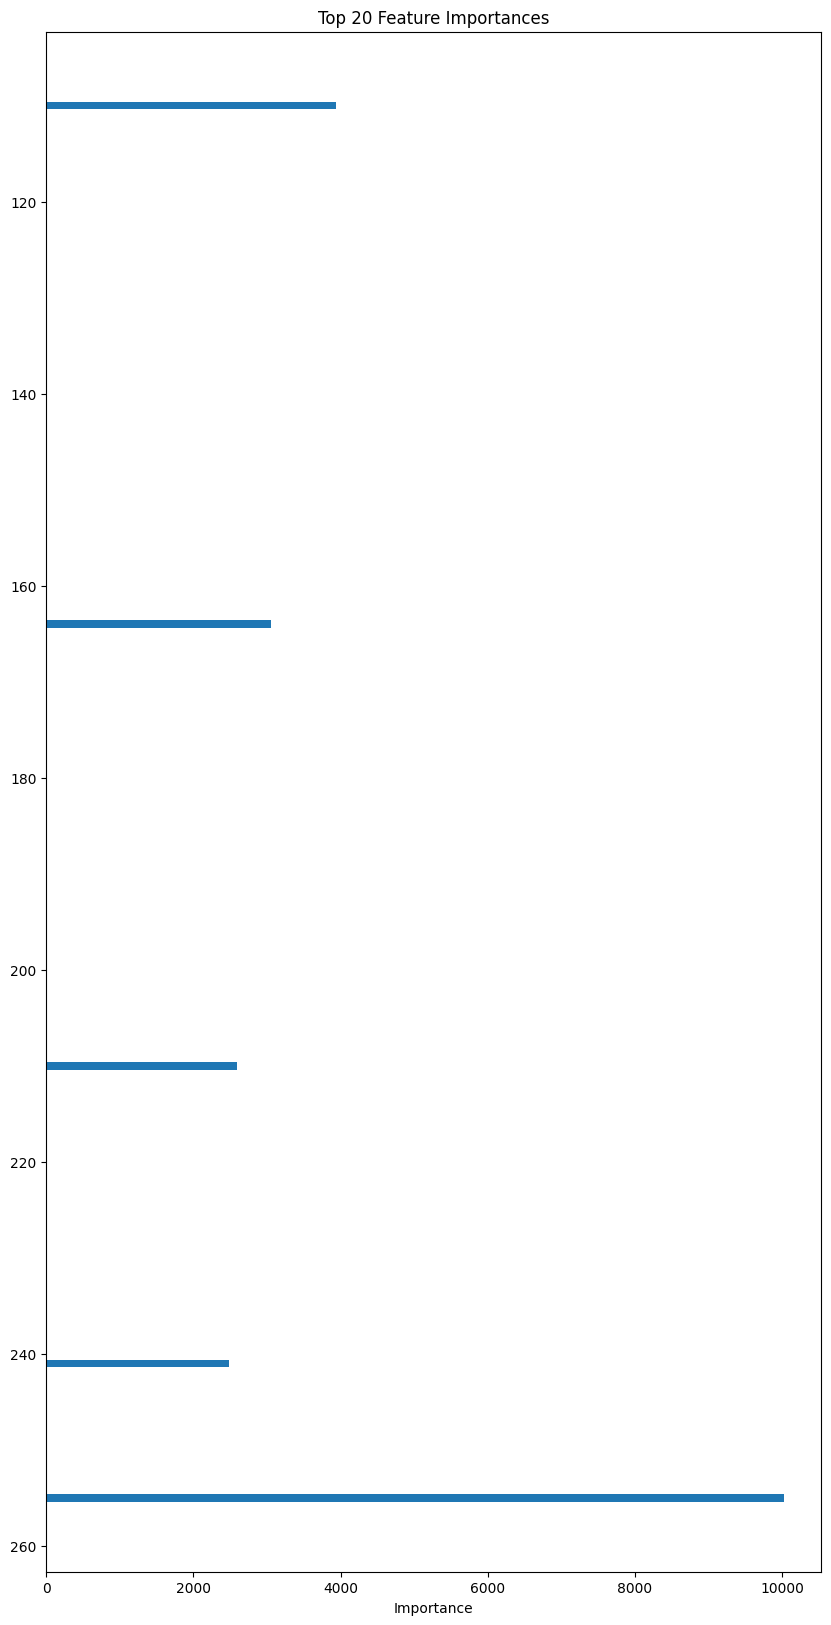

In [21]:
# 6. Evaluation
oof_log_loss = log_loss(y, oof_preds)
print(f'OOF Log Loss: {oof_log_loss}')

oof_pred_labels = np.argmax(oof_preds, axis=1)
oof_f1 = f1_score(y, oof_pred_labels,average='weighted')
print(f'OOF F1: {oof_f1}')

# 7. Feature Importance
feature_importance['importance'] /= n_splits
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 20))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.show()


In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt

# 1. Load data
train = df_train
test = df_test


X = pd.DataFrame(emb_train)
y = pd.DataFrame(1.0*(y_train_sex=='male'))
X_test = pd.DataFrame(emb_test)

# 2. Cross-validation setup
n_splits = 5
seed = 42
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# 3. Initialize predictions
oof_preds = np.zeros((X.shape[0]))
test_preds = np.zeros((X_test.shape[0], ))

# 4. LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'seed': seed,
    'verbose': -1
}

# 5. Training and prediction
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}')
    
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=400,
        valid_sets=[lgb_train, lgb_valid],
        verbose_eval=100
    )
    
    valid_preds = (model.predict(X_valid, num_iteration=model.best_iteration))>0.5
    oof_preds[valid_idx] = valid_preds
    
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / n_splits
    
    # Feature importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = list(range(256))
    fold_importance['importance'] = model.feature_importance(importance_type='gain')
    fold_importance['fold'] = fold + 1
    if fold == 0:
        feature_importance = fold_importance
    else:
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    del X_train, X_valid, y_train, y_valid, lgb_train, lgb_valid, model
    gc.collect()



Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
